In [1]:
import string
import itertools
import numpy as np
import pandas as pd
from collections import *
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### READ DATA ###

df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json.zip', lines=True)
diz_label = {0:'sarcastic', 1:'not sarcastic'}

print(df.shape)
df.head()

(28619, 3)


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


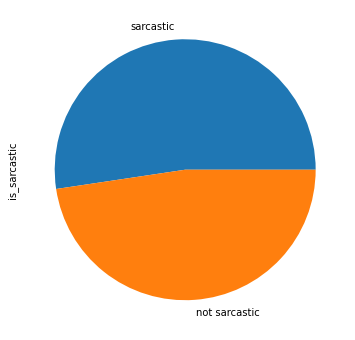

In [4]:
### PLOT LABEL DISTRIBUTION ###

df.is_sarcastic.map(diz_label).value_counts().plot.pie(figsize=(6,6))

In [5]:
### CLEAN TEXT ###

df['headline'] = df.headline.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['headline'] = df.headline.str.split()

In [6]:
### TRAIN TEST SPLIT ###

y = to_categorical(df.is_sarcastic.factorize()[0])

X_train, X_test, y_train, y_test = train_test_split(df['headline'], y, random_state=33, test_size=0.2)

In [7]:
### HOW MANY WORDS WITH LESS THEN 3 OCCURENCIES? ###

c = Counter(' '.join(X_train.str.join(' ')).split())
word = np.asarray(list(c.keys()))
freq = np.asarray(list(c.values()))

print(len(word), len(word[freq > 3]))

23601 7496


In [8]:
### TOKENIZE AND PAD SENTENCES ###

max_words = len(word[freq > 3]); max_len = 100

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)

(22895, 100) (5724, 100)


In [9]:
### DEFINE MODEL WITH MULTI-SAMPLE DROPOUT ###

def get_model(num):

    inp = Input(shape=(max_len,))
    emb = Embedding(len(tokenizer.word_index) + 1, 64)(inp)
    x = SpatialDropout1D(0.2)(emb)
    x = GRU(128, return_sequences=True, activation='relu')(x)
    out = GRU(32, activation='relu')(x)
    
    dense = []
    FC = Dense(32, activation='relu')
    for p in np.linspace(0.1,0.5, num):
        x = Dropout(p)(out)
        x = FC(x)
        x = Dense(y_train.shape[1], activation='softmax')(x)
        dense.append(x)
    
    out = Average()(dense)
    model = Model(inp, out)
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
model = get_model(3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 64)      1510528     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, 100, 128)     74496       spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [11]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=10)

model = get_model(3)
history = model.fit(sequence_train, y_train, batch_size=512, epochs=50, 
                    verbose=2, validation_split=0.1, callbacks=[es])

Epoch 1/50
41/41 - 29s - loss: 0.6697 - accuracy: 0.5539 - val_loss: 0.5624 - val_accuracy: 0.7900
Epoch 2/50
41/41 - 28s - loss: 0.4226 - accuracy: 0.8278 - val_loss: 0.3363 - val_accuracy: 0.8546
Epoch 3/50
41/41 - 29s - loss: 0.2683 - accuracy: 0.8953 - val_loss: 0.3217 - val_accuracy: 0.8642
Epoch 4/50
41/41 - 31s - loss: 0.2080 - accuracy: 0.9240 - val_loss: 0.3364 - val_accuracy: 0.8642
Epoch 5/50
41/41 - 26s - loss: 0.1701 - accuracy: 0.9405 - val_loss: 0.3786 - val_accuracy: 0.8528
Epoch 6/50
41/41 - 27s - loss: 0.1438 - accuracy: 0.9491 - val_loss: 0.4214 - val_accuracy: 0.8585
Epoch 7/50
41/41 - 25s - loss: 0.1227 - accuracy: 0.9587 - val_loss: 0.4651 - val_accuracy: 0.8502
Epoch 8/50
41/41 - 27s - loss: 0.1040 - accuracy: 0.9662 - val_loss: 0.5219 - val_accuracy: 0.8480
Epoch 9/50
41/41 - 26s - loss: 0.0874 - accuracy: 0.9723 - val_loss: 0.5691 - val_accuracy: 0.8498
Epoch 10/50
41/41 - 25s - loss: 0.0838 - accuracy: 0.9723 - val_loss: 0.5785 - val_accuracy: 0.8454
Epoch 11/

In [12]:
### GET PREDICTED CLASS ###

pred_test = np.argmax(model.predict(sequence_test), axis=1)

In [13]:
print(classification_report([diz_label[np.argmax(label)] for label in y_test], 
                            [diz_label[label] for label in pred_test]))

               precision    recall  f1-score   support

not sarcastic       0.86      0.84      0.85      3017
    sarcastic       0.83      0.85      0.84      2707

     accuracy                           0.85      5724
    macro avg       0.85      0.85      0.85      5724
 weighted avg       0.85      0.85      0.85      5724



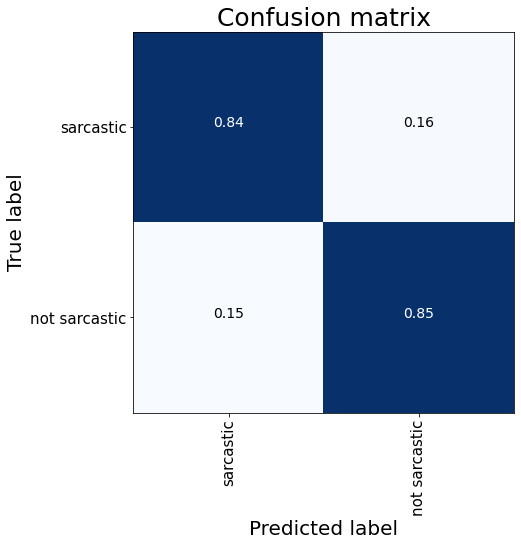

In [14]:
cnf_matrix = confusion_matrix([diz_label[np.argmax(label)] for label in y_test], 
                              [diz_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()))
plt.show()